In [7]:
from pytket.extensions.nexus import Nexus
from datetime import datetime
from pytket.extensions.nexus import QuantinuumConfig
from pytket.extensions.nexus import NexusBackend
import pytket as tk
from pytket import passes as tkp
from pytket import circuit as tkc

from pytket.circuit.display import render_circuit_jupyter as print_circ

import numpy as np
from pytket import Circuit
from pytket import OpType
from pytket.circuit.display import render_circuit_jupyter

In [3]:
print("something")

something


### Define a helper function to make measurement 

In [8]:
def get_res(name, my_circuit, shots):
    configuration = QuantinuumConfig(device_name="H1-1LE", user_group="iQuHACK_2024")
    nexus = Nexus()
    my_project = nexus.new_project(name=name)
    # Then we'll create a NexusBackend using our config and the project we created
    backend = NexusBackend(configuration, project=my_project)
    compiled_circuit = backend.get_compiled_circuit(my_circuit, optimisation_level=2)
    handle = backend.process_circuit(compiled_circuit, n_shots=shots)
    backend.circuit_status(handle)
    result = backend.get_result(handle)
    result.get_distribution()


In [43]:
c = Circuit(3).CX(0,1).H(1).CX(1,2).H(1).H(2)
c.measure_all()
print_circ(c)

In [44]:
get_res("original_cir_2", c, 1000)


New project created: original_cir_2

Started using project with name: original_cir_2


In [6]:
for g in c:
    print(g)

CX q[0], q[1];
H q[1];
CX q[1], q[2];
H q[1];
H q[2];


In [50]:
num_qbit = 3
c = Circuit(num_qbit).CX(0,1).H(1).T(1).CX(1,2).H(1).H(2).T(0).T(2)

print_circ(c)
def H_gadgets(c:Circuit):
    d = Circuit(c.n_qubits)
    num_H = c.n_gates_of_type(OpType.H)
    ancilla_q = d.add_q_register("a", num_H)
    cr = d.add_c_register("c", num_H+c.n_qubits)
    # cr_for_qbit = d.add_c_register("cq", c.n_qubits)
    count_ancilla = 0
    for g in c:
        if g.op.type == OpType.H:
            print("find H gate")
            count_ancilla += 1
            anc_act = ancilla_q[count_ancilla-1]
            d.H(anc_act)
            d.S(g.qubits[0])
            d.S(anc_act)
            d.CX(g.qubits[0], anc_act)
            d.Sdg(anc_act)
            d.CX(anc_act,g.qubits[0])
            d.CX(g.qubits[0], anc_act)
            d.Measure(anc_act,cr[count_ancilla-1])
            d.X(*g.qubits,condition_bits=[cr[count_ancilla-1]], condition_value=1)
        else:
            d.add_gate(g.op, g.qubits)
    return d
print_circ(H_gadgets(c))

find H gate
find H gate
find H gate


In [52]:
d = H_gadgets(c)
# get_res("big_circuit", d, 1000)

find H gate
find H gate
find H gate


In [53]:
print_circ(d)

In [1]:
from pytket.extensions.nexus.backends import Nexus

nexus = Nexus()
project = nexus.get_project_by_name("big_circuit")
results = project.get_all_results()



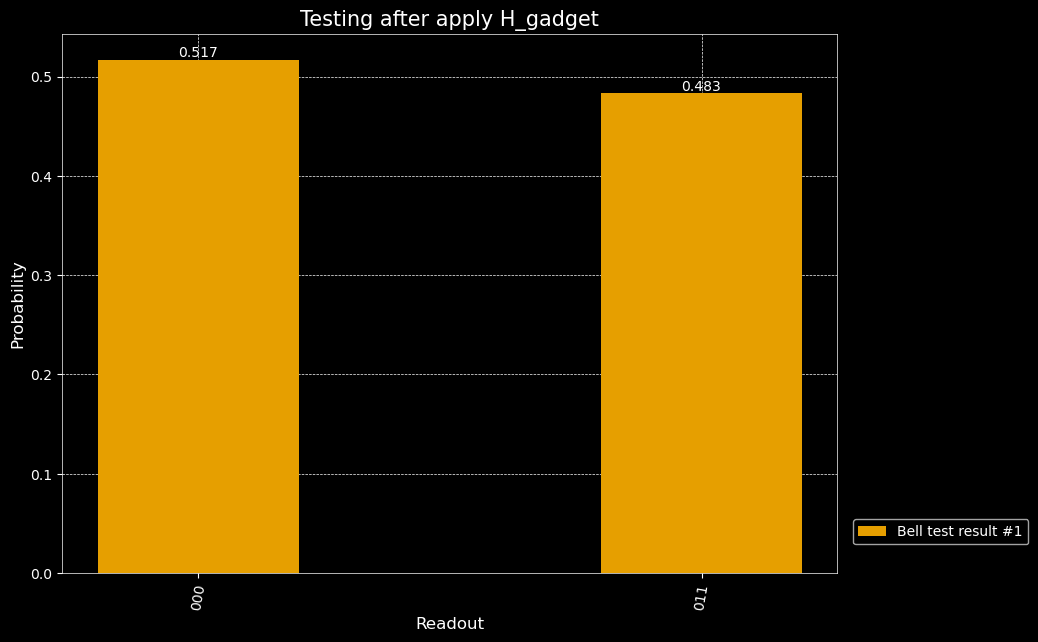

In [4]:
from pytket.extensions.nexus.visualisation import plot_results_histogram

# plot the histogram, supplying a list containing the results to plot
plot_results_histogram(
    results=results[:1],
    legend=["Bell test result #1"],
    title="Testing after apply H_gadget",
)



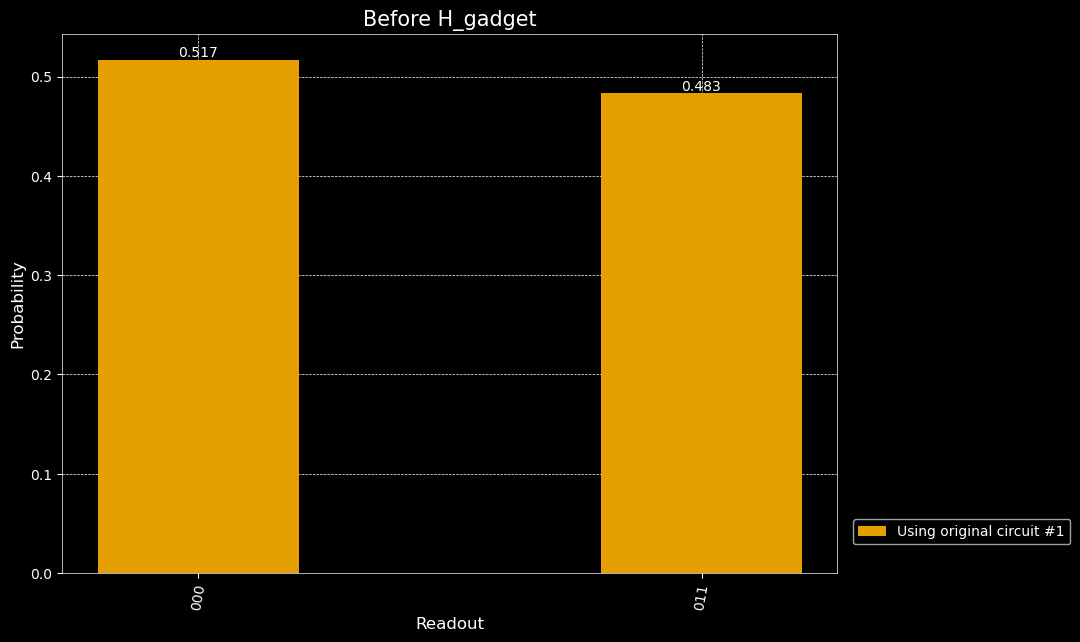

In [5]:
project_ori = nexus.get_project_by_name("original_cir_2")
results_ori = project.get_all_results()
plot_results_histogram(
    results=results[:1],
    legend=["Using original circuit #1"],
    title="Before H_gadget",
)

### More qubits

In [59]:
new_c = Circuit(4).CX(0,1).H(1).CX(1,2).H(1).H(2).CX(2,3).T(1).S(2)
# c.measure_all()
print_circ(new_c)
H_new_c = H_gadgets(new_c)
new_c.measure_all()
# get_res("new_c_original_3", new_c, 1000)

find H gate
find H gate
find H gate


[CX q[0], q[1]; Measure q[0] --> c[0]; H q[1]; CX q[1], q[2]; H q[1]; H q[2]; T q[1]; CX q[2], q[3]; Measure q[1] --> c[1]; Measure q[3] --> c[3]; S q[2]; Measure q[2] --> c[2]; ]

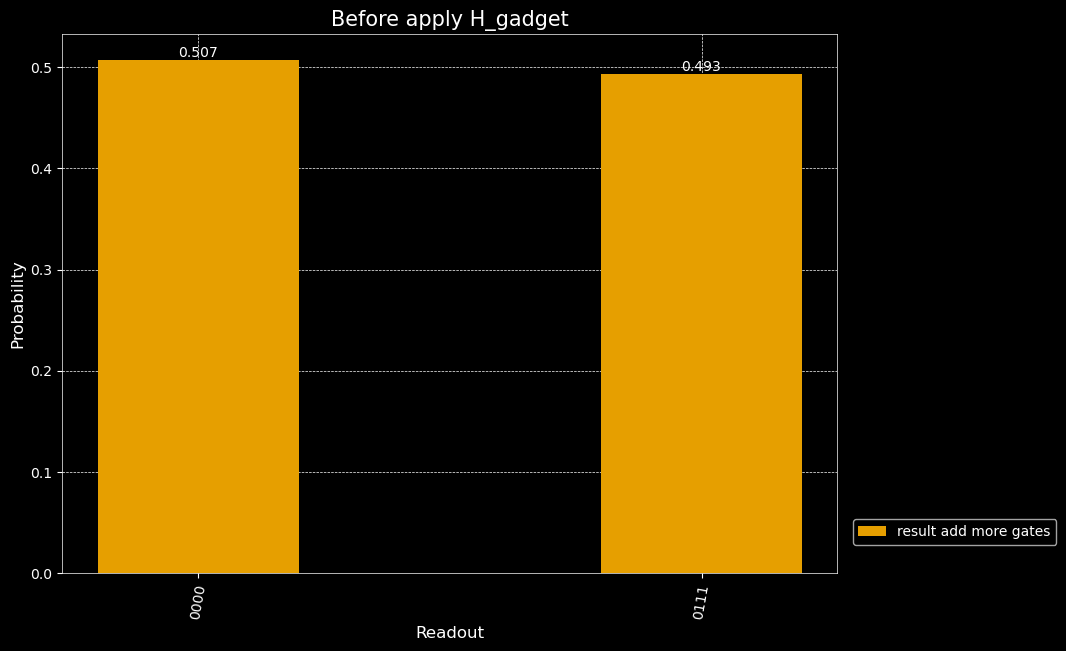

In [29]:
project = nexus.get_project_by_name("new_c_original_3")
results = project.get_all_results()
plot_results_histogram(
    results=results[:1],
    legend=["result add more gates"],
    title="Before apply H_gadget",
)


In [43]:
print_circ(H_new_c)
# H_new_c.measure_all()

In [61]:
# for i in range(3,8):
# cq_4 = Bit("cq", 0)
H_new_c.Measure(0,3)
H_new_c.Measure(1,4)
H_new_c.Measure(2,5)
H_new_c.Measure(3,6)
# for g in H_new_c:
#     print(g.op, g.qubits)
print_circ(H_new_c)


In [62]:
get_res("Result_complex", H_new_c , 1000)


New project created: Result_complex

Started using project with name: Result_complex


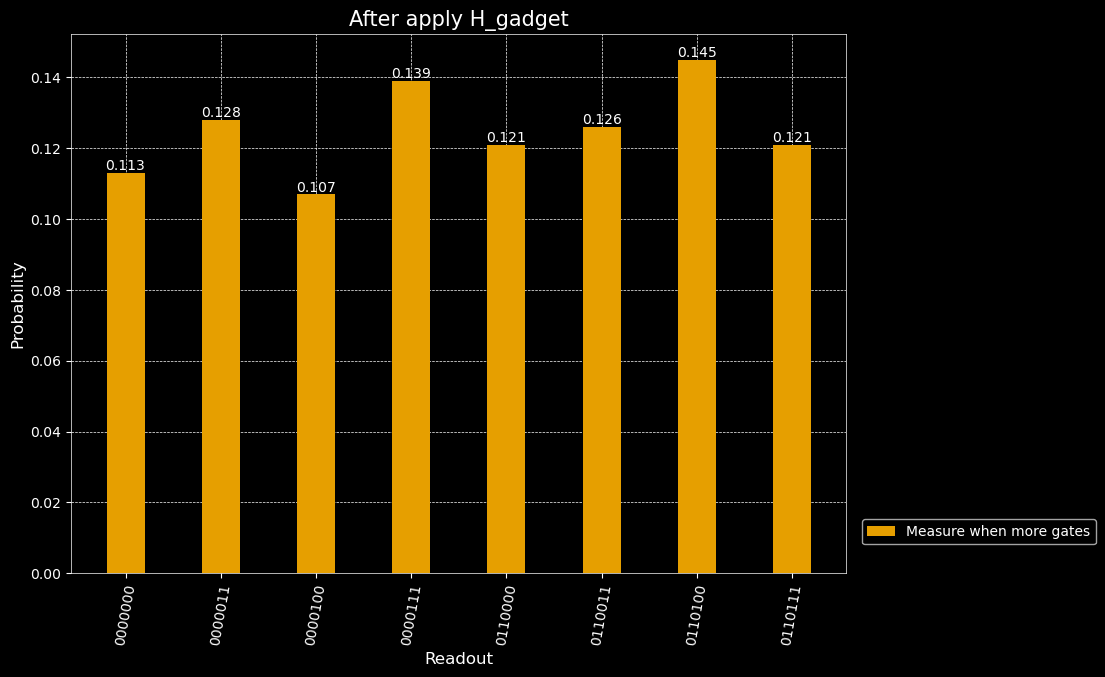

In [63]:
project = nexus.get_project_by_name("Result_complex")
results = project.get_all_results()
plot_results_histogram(
    results=results[:1],
    legend=["Measure when more gates"],
    title="After apply H_gadget",
)

### Test simple case

In [71]:
c = Circuit(1)
c.add_c_register("c",1)
c.H(0)
print_circ(c)
c.Measure(0,0)

[H q[0]; Measure q[0] --> c[0]; ]

In [72]:
get_res("Simple_measure", c , 1000)


New project created: Simple_measure

Started using project with name: Simple_measure


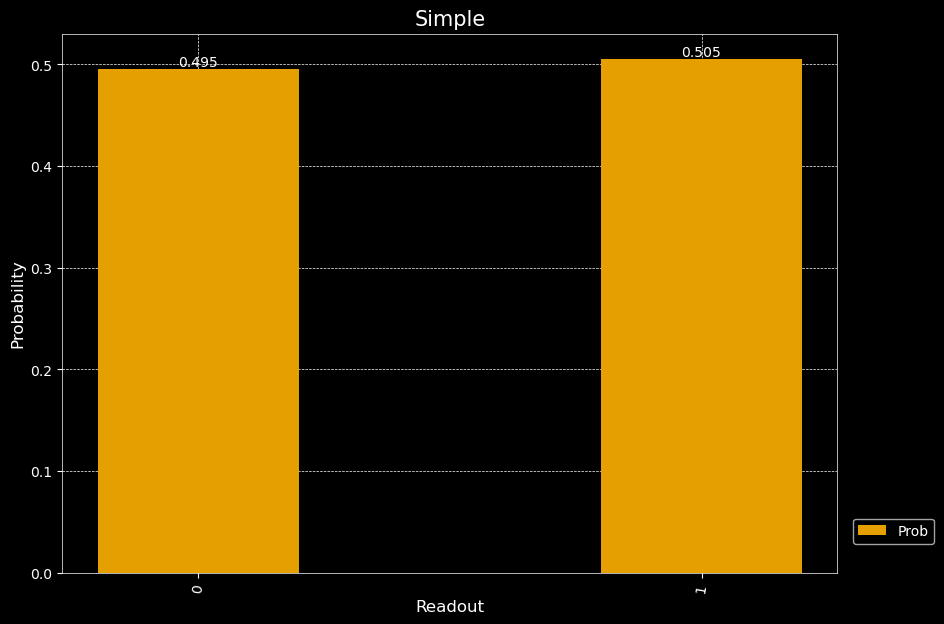

In [73]:
project = nexus.get_project_by_name("Simple_measure")
results = project.get_all_results()
plot_results_histogram(
    results=results[:1],
    legend=["Prob"],
    title="Simple",
)

In [78]:
c = Circuit(1)
c.H(0)
print_circ(c)
# c.Measure(0,0)
H_c_simp = H_gadgets(c)
print_circ(H_c_simp)

find H gate


In [81]:
H_c_simp.Measure(0,1)

[H a[0]; S q[0]; S a[0]; CX q[0], a[0]; Sdg a[0]; CX a[0], q[0]; CX q[0], a[0]; Measure a[0] --> c[0]; IF ([c[0]] == 1) THEN X q[0]; Measure q[0] --> c[1]; ]

In [82]:
get_res("Simple_meas_H", H_c_simp , 1000)


New project created: Simple_meas_H

Started using project with name: Simple_meas_H


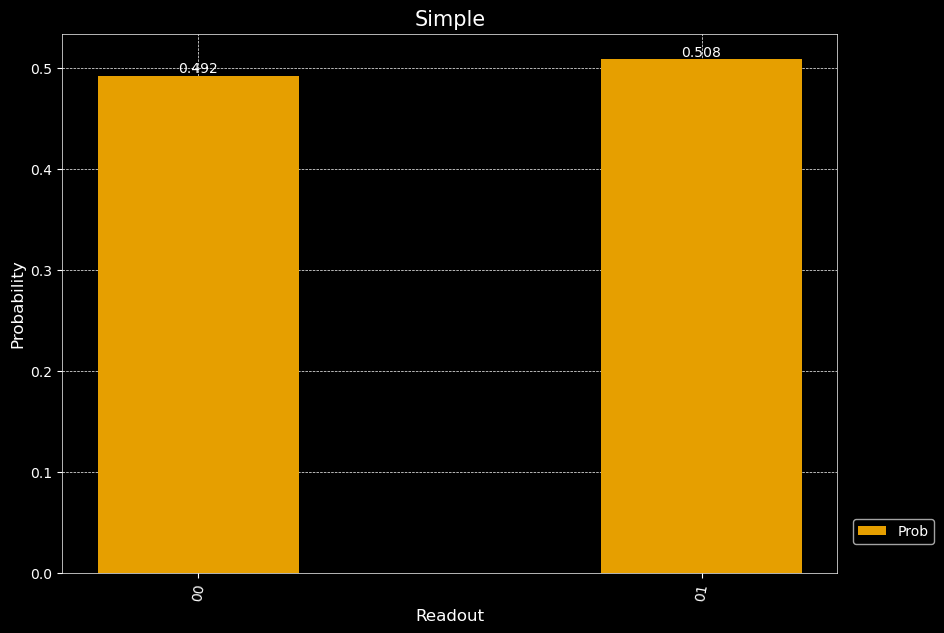

In [83]:
project = nexus.get_project_by_name("Simple_meas_H")
results = project.get_all_results()
plot_results_histogram(
    results=results[:1],
    legend=["Prob"],
    title="Simple",
)

In [88]:
c = Circuit(2).H(0).CX(0,1).H(0).H(1)
c.measure_all()
print_circ(c)

In [89]:
get_res("Bell_test_simp", c , 1000)


New project created: Bell_test_simp

Started using project with name: Bell_test_simp


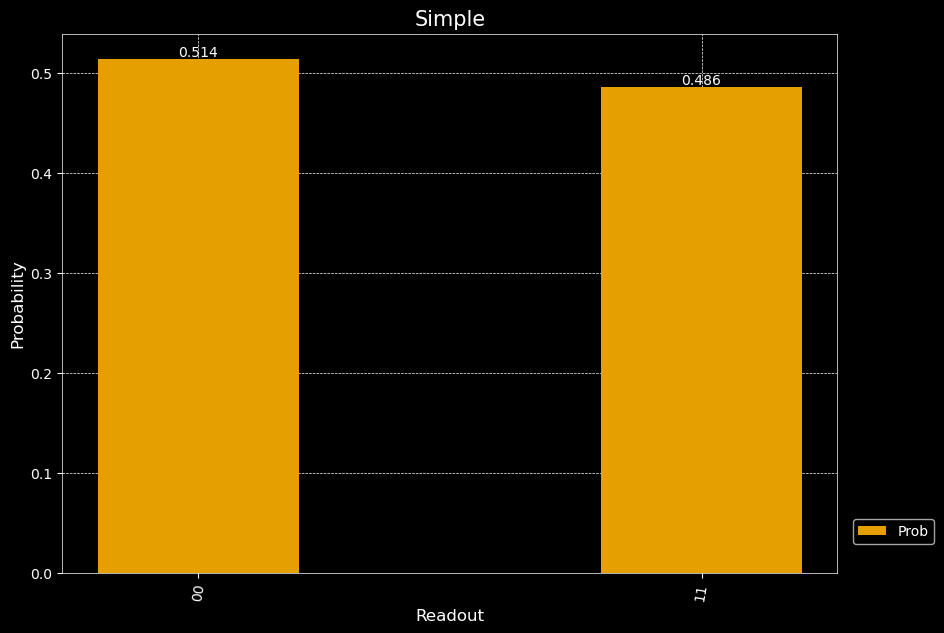

In [90]:
project = nexus.get_project_by_name("Bell_test_simp")
results = project.get_all_results()
plot_results_histogram(
    results=results[:1],
    legend=["Prob"],
    title="Simple",
)

In [91]:
c = Circuit(2).H(0).CX(0,1).H(0).H(1)
h_c = H_gadgets(c)
print_circ(h_c)

find H gate
find H gate
find H gate


In [ ]:
h_c.measure_all()

In [93]:
get_res("H_gadgets_Bell", h_c , 1000)


New project created: H_gadgets_Bell

Started using project with name: H_gadgets_Bell


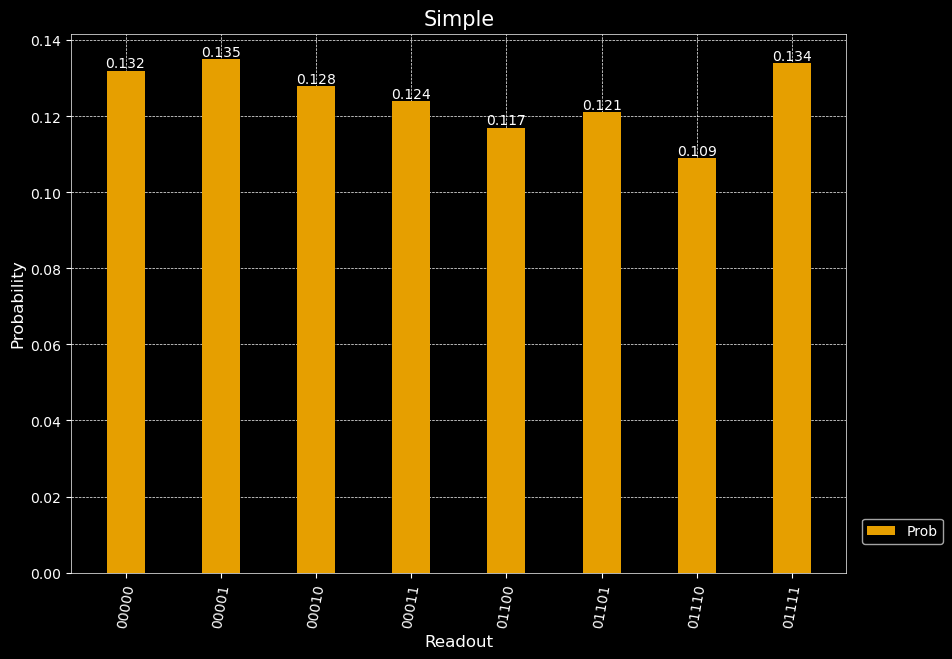

In [99]:
project = nexus.get_project_by_name("H_gadgets_Bell")
results = project.get_all_results()
plot_results_histogram(
    results=results[:1],
    # result = results.get_counts(keys=[3, 4]),
    legend=["Prob"],
    title="Simple",
)

In [101]:
print_circ(h_c)